# Info

* Предсказание категории с помощью kNN.
* Выбор оптимального значения гипермараметра `TOP_K`.
* Оценка качества на валидации.

# Settings

In [ ]:
# Files
GDRIVE_DIR = r'/content/drive/MyDrive/DS/20230314_ke-intern-test/'

DATASET_DIR = GDRIVE_DIR + 'dataset/'

TRAIN_EMB_NPZ = GDRIVE_DIR + 'embeddings_text_train.npz'
VAL_EMB_NPZ = GDRIVE_DIR + 'embeddings_text_val.npz'

# Reproducibility
SEED = 1

# Init

## Imports

In [ ]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import torch

# Main

## Loading data

In [ ]:
train_emb_npz = np.load(TRAIN_EMB_NPZ)
val_emb_npz = np.load(VAL_EMB_NPZ)

train_embs = train_emb_npz['embeddings']
train_labels = train_emb_npz['labels']

val_embs = val_emb_npz['embeddings']
val_labels = val_emb_npz['labels']

train_embs.shape, train_labels.shape, val_embs.shape, val_labels.shape

((81120, 768), (81120,), (10000, 768), (10000,))

### Search best top_k

In [ ]:
# Precompute all similarity scores
similarity_scores = torch.as_tensor(val_embs @ train_embs.T)  # torch.Size([10000, 81120])

In [ ]:
from sklearn.metrics import f1_score

train_labels_pt = torch.as_tensor(train_labels.astype(np.int64))

scores = []

for top_k in tqdm(range(1, 20 + 1)):
    _, pred_indices = torch.topk(similarity_scores, k=top_k)  # torch.Size([10000, top_k])
    pred_top_k_labels = train_labels_pt[pred_indices]  # torch.Size([10000, top_k])
    pred_labels = torch.mode(pred_top_k_labels).values  # torch.Size([10000])

    score = f1_score(val_labels, pred_labels, average='weighted')
    scores.append({'top_k': top_k, 'f1_score': score})

  0%|          | 0/20 [00:00<?, ?it/s]

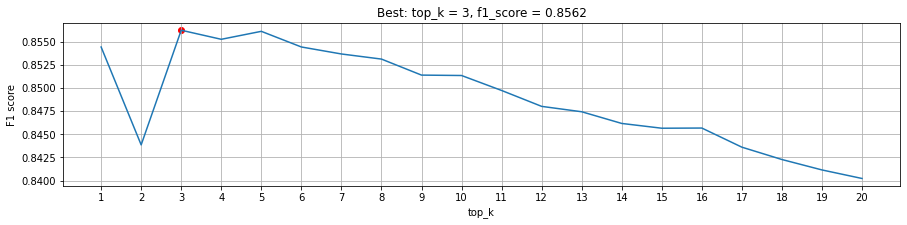

In [ ]:
scores = pd.DataFrame(scores)

plt.figure(figsize=(15, 3))
plt.plot(scores.top_k, scores.f1_score)
plt.xticks(range(1, 20 + 1))
plt.grid()
plt.xlabel('top_k')
plt.ylabel('F1 score')

max_score_idx = scores.f1_score.argmax()
best_top_k, best_f1_score = scores.loc[max_score_idx]
plt.title(f'Best: top_k = {best_top_k:.0f}, f1_score = {best_f1_score:.4f}')
plt.scatter(best_top_k, best_f1_score, c='r')
pass

Оптимальное значение `top_k = 3 `.

### Save preds

In [ ]:
TOP_K = 3

train_labels_pt = torch.as_tensor(train_labels.astype(np.int64))

_, pred_indices = torch.topk(similarity_scores, k=TOP_K)  # torch.Size([10000, top_k])
pred_top_k_labels = train_labels_pt[pred_indices]  # torch.Size([10000, top_k])
pred_labels = torch.mode(pred_top_k_labels).values  # torch.Size([10000])

In [ ]:
df_preds = pd.DataFrame({
    'product_id': val_emb_npz['product_ids'],
    'true_label': val_emb_npz['labels'],
    'pred_label_knn_3': pred_labels,
})
df_preds

,product_id,true_label,pred_label_knn_3
0,1689792,284,284
1,331216,9,3
2,1180499,297,297
3,1757201,154,29
4,327910,71,71
...,...,...,...
9995,1738054,0,0
9996,909192,67,147
9997,1998309,47,47
9998,1913062,0,0


In [ ]:
df_preds.to_csv(GDRIVE_DIR + 'val_preds_knn_3.csv', index=False)